# Neuroevolution with CMA-ME: Training a Simple MNIST Network

https://github.com/hardmaru/pytorch_notebooks/blob/master/mnist_es/pytorch_mnist_mini_es_cma.ipynb

In [1]:
%pip install ribs torch torchvision tqdm scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import torch
import torch.nn as nn
import torchvision
import tqdm
from sklearn.metrics import confusion_matrix

from ribs.archives import GridArchive
from ribs.emitters import GaussianEmitter
from ribs.optimizers import Optimizer

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Data

In [4]:
TRAIN_BATCH_SIZE = 1000
TEST_BATCH_SIZE = 1000

MEAN_TRANSFORM = 0.1307
STD_DEV_TRANSFORM = 0.3081

# Transform each image by turning it into a tensor and then
# normalizing the values.
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAINLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=mnist_transforms),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)
TESTLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=False,
                               transform=mnist_transforms),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
)

## Network

In [5]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1,
                      padding=0),  # (1,28,28) -> (6,24,24)
            nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
            nn.ReLU(),
            nn.Conv2d(6, 16, (5, 5), stride=1,
                      padding=0),  # (6,12,12) -> (16,8,8)
            nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
            nn.ReLU(),
            nn.Flatten(),  # (16,4,4) -> (256,)
            nn.Linear(256, 10),  # (256,) -> (10,)
            nn.LogSoftmax(dim=1),  # (10,) output probabilities
        )

        self.model_shapes = []
        self.n_params = 0
        for param in self.model.parameters():
            p = param.data.cpu().numpy()
            self.model_shapes.append(p.shape)
            self.n_params += np.product(p.shape)

    def forward(self, x):
        return self.model(x)

    def update_model(self, flat_params):
        """Updates the model parameters with the given flat params."""
        flat_idx = 0
        block_idx = 0
        for param in self.model.parameters():
            delta = np.product(self.model_shapes[block_idx])
            block = flat_params[flat_idx:flat_idx + delta]
            block = np.reshape(block, self.model_shapes[block_idx])
            block_idx += 1
            flat_idx += delta
            param.data = torch.from_numpy(block).float().to(device)

## Training

In [6]:
def infinite_loader(loader):
    """Enables one to cycle through shuffled versions of a dataset."""
    iterable = iter(TRAINLOADER)
    while True:
        try:
            batch = next(iterable)
        except StopIteration:
            iterable = iter(TRAINLOADER)
            batch = next(iterable)
        yield batch

Params: 5142
Iteration 100 complete after 193.12674570083618 s
Number cells: 559
Mean fitness: -9316.418250341534


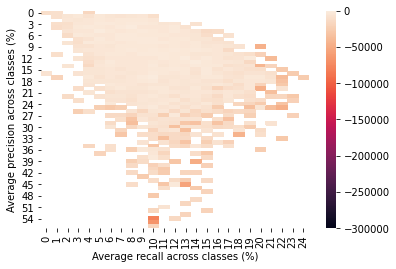

Iteration 200 complete after 383.84173703193665 s
Number cells: 726
Mean fitness: -11639.788315870217


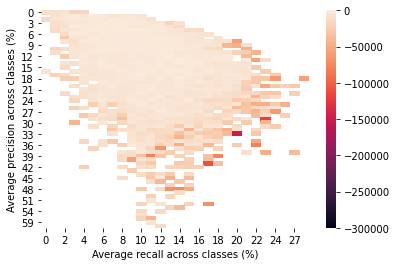

Iteration 300 complete after 565.6285500526428 s
Number cells: 835
Mean fitness: -13428.353561602382


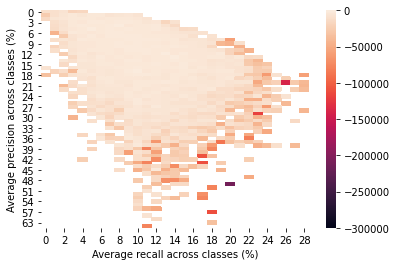

Iteration 400 complete after 758.2069399356842 s
Number cells: 937
Mean fitness: -19358.42257374506


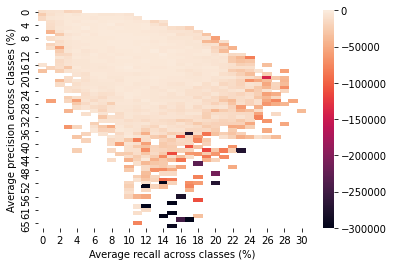

Iteration 500 complete after 951.6314542293549 s
Number cells: 1041
Mean fitness: -31996.912852057347


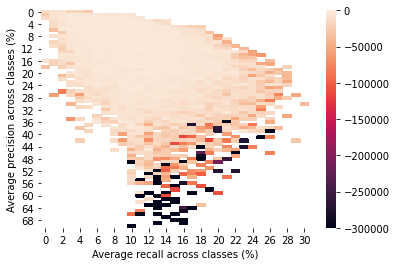

Iteration 600 complete after 1162.159327507019 s
Number cells: 1157
Mean fitness: -42952.735440873235


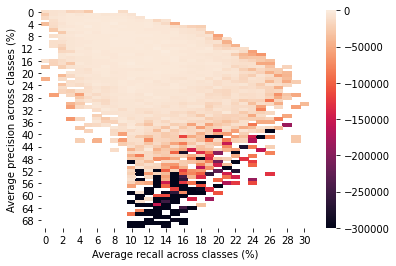

Iteration 700 complete after 1382.7319867610931 s
Number cells: 1258
Mean fitness: -47772.5418530875


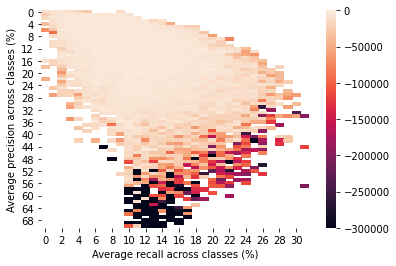

Iteration 800 complete after 1573.5426666736603 s
Number cells: 1344
Mean fitness: -50280.07358837128


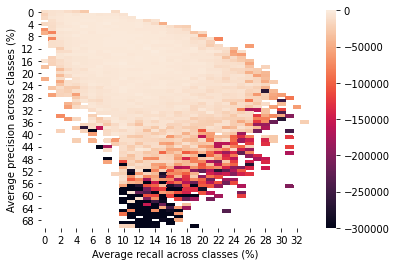

Iteration 900 complete after 1764.0497000217438 s
Number cells: 1404
Mean fitness: -51979.380680051625


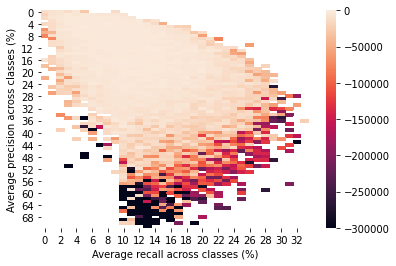

Iteration 1000 complete after 1963.371571302414 s
Number cells: 1478
Mean fitness: -54013.349952419005


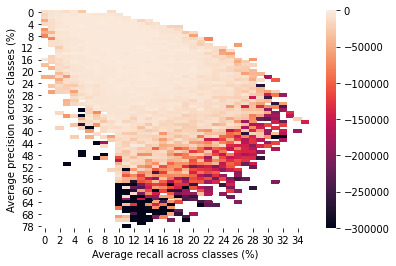

In [7]:
net = Net().to(device)
loader = infinite_loader(TRAINLOADER)
nll_loss = nn.NLLLoss()

archive = GridArchive([100, 100], [(0, 1), (0, 1)])
emitters = [GaussianEmitter(np.zeros(net.n_params), 1, archive)]
optimizer = Optimizer(archive, emitters)

print("Params:", net.n_params)
start_time = time.time()

for itr in range(1000):
    solutions = optimizer.ask()

    objs = []
    bcs = []
    images, labels = next(loader)
    for sol in solutions:

        # Evaluate the solution.
        net.update_model(sol)
        with torch.no_grad():
            results = net(images.to(device))
            _, predicted = torch.max(results.to("cpu"), 1)
            loss = nll_loss(results, labels.to(device)).item()

        # Objective is to minimize loss (i.e. maximize negative loss).
        objs.append(-loss)

        # BCs are the precision and recall.
        confusion = confusion_matrix(labels, predicted)

        # True positives are on diagonal.
        true_pos = confusion[np.arange(10), np.arange(10)]

        precision = np.sum(confusion, axis=0)
        nonzero = np.where(precision != 0)
        precision = true_pos[nonzero] / precision[nonzero]
        precision = np.mean(precision)

        recall = np.sum(confusion, axis=1)
        nonzero = np.where(recall != 0)
        recall = true_pos[nonzero] / recall[nonzero]
        recall = np.mean(recall)

        bcs.append([precision, recall])

    optimizer.tell(objs, bcs)

    if (itr + 1) % 100 == 0:
        print(
            f"Iteration {itr + 1} complete after {time.time() - start_time} s")
        data = archive.as_pandas()
        print("Number cells:", len(data))
        print("Mean fitness:", data["objective"].mean())
        sns.heatmap(data.pivot("index_0", "index_1", "objective"), vmin=-300_000, vmax=0)
        plt.ylabel("Average precision across classes (%)")
        plt.xlabel("Average recall across classes (%)")
        plt.show()

## Comparing to Test Archive

We can see that the test archive does not match (in particular, it has much lower precision, though recall seems to hold up), but it is hard to get a good estimate during training because we can only do so many evaluations. Essentially, this shows that our BCs (and our fitness, though that is not as big of an issue since more items = more loss) are somewhat inaccurate.

TODO: Refactor

Number cells: 844
Mean fitness: -570255.2834401063


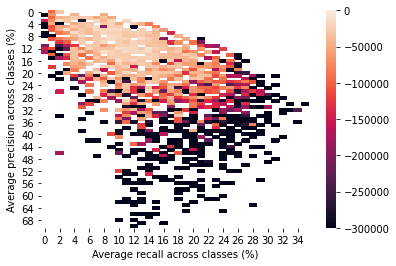

In [12]:
solutions = archive.as_pandas().loc[:, "solution-0":].to_numpy()
test_archive = GridArchive([100, 100], [(0, 1), (0, 1)])
test_archive.initialize(solutions.shape[1])


for sol in solutions:

    # Evaluate the solution.
    net.update_model(sol)
    labels = []
    predicted = []
    with torch.no_grad():
        loss = 0
        for batch_images, batch_labels in TESTLOADER:
            results = net(batch_images.to(device))
            _, batch_predict = torch.max(results.to("cpu"), 1)
            labels.append(batch_labels)
            predicted.append(batch_predict)
            loss += nll_loss(results, batch_labels.to(device)).item()
        labels = torch.cat(labels)
        predicted = torch.cat(predicted)

    # Objective is to minimize loss (i.e. maximize negative loss).
    obj = -loss

    # BCs are the precision and recall.
    confusion = confusion_matrix(labels, predicted)

    # True positives are on diagonal.
    true_pos = confusion[np.arange(10), np.arange(10)]

    precision = np.sum(confusion, axis=0)
    nonzero = np.where(precision != 0)
    precision = true_pos[nonzero] / precision[nonzero]
    precision = np.mean(precision)

    recall = np.sum(confusion, axis=1)
    nonzero = np.where(recall != 0)
    recall = true_pos[nonzero] / recall[nonzero]
    recall = np.mean(recall)

    bcs = np.array([precision, recall])
    
    test_archive.add(sol, obj, bcs)
    
data = test_archive.as_pandas()
print("Number cells:", len(data))
print("Mean fitness:", data["objective"].mean())
sns.heatmap(data.pivot("index_0", "index_1", "objective"), vmin=-300_000, vmax=0)
plt.ylabel("Average precision across classes (%)")
plt.xlabel("Average recall across classes (%)")
plt.show()